# UCI 信用卡数据集的二元分类分析

## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-card-Default-Dataset)
1. [Using a Fairness Unaware Model](#Using-a-Fairness-Unaware-Model)
1. [Mitigating Equalized Odds Difference with Postprocessing](#Mitigating-Equalized-Odds-Difference-with-Postprocessing)
1. [Mitigating Equalized Odds Difference with GridSearch](#Mitigating-Equalized-Odds-Difference-with-GridSearch)

## 具体内容

* **涉及领域：**
  * 金融贷款方面的决策分析。我们分析的数据是原始数据经过人工简单处理过的，是为了展现准确性方面的悬殊差异。

* **机器学习任务：**
  * 二元性分类

* **机器学习公平任务：**
  * 使用Fairlearn metrics和Fairlearn dashboard来评估模型的公平。
  * 使用Fairlearn中的改进算法来改进模型的公平水平。

* **性能指标：**
  * ROC曲线下的面积。
  * 平衡过后的准确率。

* **公平指标：**
  * Equalized-odds difference.

* **改进的算法:**
  * `fairlearn.reductions.GridSearch`
  * `fairlearn.postprocessing.ThresholdOptimizer`

## 简介

在这个例子中，我们模拟了贷款决策中出现的准确性差异问题。具体来说，我们考虑的情况是，算法工具根据历史数据进行训练，其对贷款申请人的预测被用于对申请人做出决定。关于涉及信用额度决策中基于性别的歧视的例子，请看[这里](https://www.nytimes.com/2019/11/10/business/Apple-credit-card-investigation.html)。

我们使用[UCI信用卡数据集](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)。为了这个练习，我们修改了原始的UCI数据集：我们引入了一个合成特征，该特征对女性客户有很强的预测能力，但对男性申请人没有信息。我们拟合了各种预测客户违约的模型。我们表明，一个没有公平意识的训练算法可以导致一个预测器对女性的准确率远远高于男性，而且简单地从训练中删除敏感特征（在这种情况下为性别）是不够的。然后我们使用`ThresholdOptimizer`和`GridSearch`来改进模型。

In [9]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.widget import FairlearnDashboard
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Metrics
from fairlearn.metrics import (
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    #balanced_accuracy_score_group_summary, 
    #roc_auc_score_group_summary,
    equalized_odds_difference
    #difference_from_summary
    #difference
    )

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

## UCI信用卡数据集

UCI数据集包含30,000名客户及其在台湾一家银行的信用卡交易数据。除了客户的静态特征外，该数据集还包含2005年4月至9月的信用卡账单支付历史，以及客户信用卡的余额限制。目标是客户是否会在接下来的一个月，即2005年10月拖欠信用卡付款。可以想象，在这个数据上训练出来的模型在实践中可以用来确定客户是否有资格获得其他产品，如汽车贷款等。

### 总体查看数据集信息

In [3]:
# Load the data
data_url = "credit card clients.xls"
dataset = pd.read_excel(data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


数据集属性:

* `LIMIT_BAL`: 信用卡限额，会被替换成一个合成的更具典型性的特征。
* `SEX, EDUCATION, MARRIAGE, AGE`: 客户个人信息。
* `BILL_AMT[1-6]`: 客户4-9月份的账单信息。
* `PAY_AMT[1-6]`: 客户4-9月份的还款信息。
* `default payment next month`: 目标属性, 用户是否会在下一个月拖欠信用卡还款。

In [4]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   30000 non-null  int64   
 1   SEX                         30000 non-null  int64   
 2   EDUCATION                   30000 non-null  category
 3   MARRIAGE                    30000 non-null  category
 4   AGE                         30000 non-null  int64   
 5   PAY_1                       30000 non-null  category
 6   PAY_2                       30000 non-null  category
 7   PAY_3                       30000 non-null  category
 8   PAY_4                       30000 non-null  category
 9   PAY_5                       30000 non-null  category
 10  PAY_6                       30000 non-null  category
 11  BILL_AMT1                   30000 non-null  int64   
 12  BILL_AMT2                   30000 non-null  int64   
 13  BILL_AMT3       

In [6]:
dataset.describe()

,LIMIT_BAL,SEX,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
dataset.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

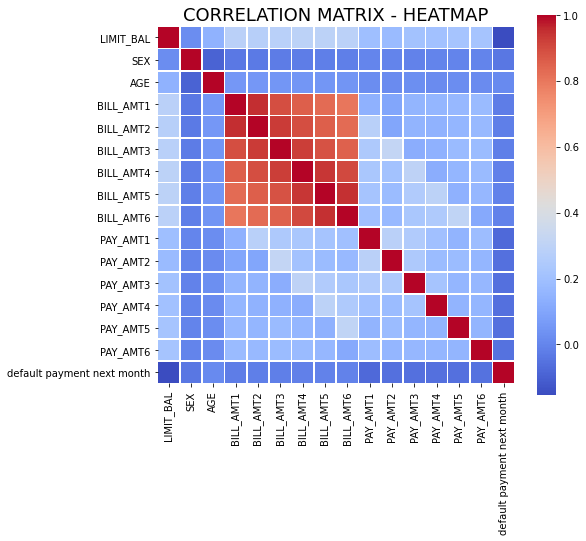

In [10]:
#  looking at correlations matrix, defined via Pearson function
#  观察通过皮尔逊函数定义的相关矩阵。 
corr = dataset.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

In [16]:
#Segregating the numeric and categorical variable names

numeric=[key for key in dict(dataset.dtypes) if dict(dataset.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
catgorical=[key for key in dict(dataset.dtypes) if dict(dataset.dtypes)[key] in ['object']]
print('numerical = ' ,numeric)
print('categorical = ' ,catgorical)

numerical =  ['LIMIT_BAL', 'SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']
categorical =  []


In [21]:
##t检验
## performing the independent t test on numerical variables
import scipy.stats as stats
#make a dataframe
tstats_df = pd.DataFrame()
# run a loop for all numerical variable
for eachvariable in numeric:
    
    tstats = stats.ttest_ind(dataset.loc[dataset["default payment next month"] == 1,eachvariable],dataset.loc[dataset["default payment next month"] == 0, eachvariable],equal_var=False)
    temp = pd.DataFrame([eachvariable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
    
tstats_df =  tstats_df.sort_values(by = "P-Value").reset_index(drop = True)
tstats_df

,Variable Name,T-Statistic,P-Value
0,default payment next month,inf,0
1,LIMIT_BAL,-28.9516,3.3641e-178
2,PAY_AMT1,-17.5125,3.54587e-68
3,PAY_AMT2,-14.8172,1.88197e-49
4,PAY_AMT4,-12.2221,3.37478e-34
5,PAY_AMT3,-11.8935,1.78062e-32
6,PAY_AMT5,-11.2457,3.23577e-29
7,PAY_AMT6,-11.058,2.59137e-28
8,SEX,-6.85849,7.34902e-12
9,BILL_AMT1,-3.39776,0.000681892


### 逐个属性查看相关性

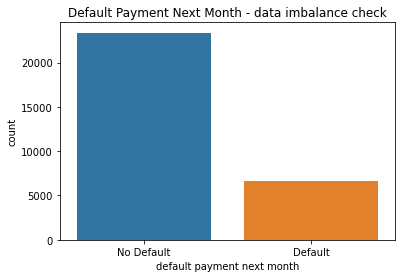

In [23]:
dataset['default payment next month'].value_counts()
plt.title('Default Payment Next Month - data imbalance check')
ax1 = sns.countplot(x = 'default payment next month', data = dataset)
ax1.set_xticklabels(['No Default','Default'])
plt.show()

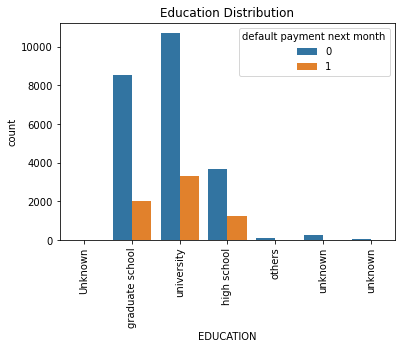

In [25]:
# Education Distribution
plt.title('Education Distribution')
ax2 = sns.countplot(x= 'EDUCATION', hue = 'default payment next month', data = dataset)
ax2.set_xticklabels(['Unknown','graduate school','university','high school','others','unknown','unknown'],rotation = 90)
plt.show()

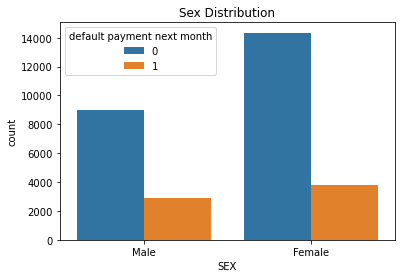

In [26]:
# SEX distribution
plt.title('Sex Distribution')
ax3 = sns.countplot(x= 'SEX', hue = 'default payment next month', data = dataset)
ax3.set_xticklabels(['Male','Female'])
plt.show()

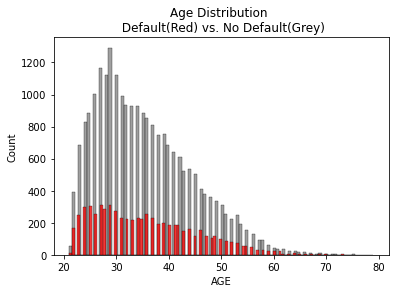

In [32]:
# Age Distribution
plt.title('Age Distribution \n Default(Red) vs. No Default(Grey)')
agedist0 = dataset[dataset['default payment next month']==0]['AGE']
agedist1 = dataset[dataset['default payment next month']==1]['AGE']
sns.histplot(agedist0, bins = 100, color = 'grey')
sns.histplot(agedist1, bins = 100, color = 'red')
plt.show()

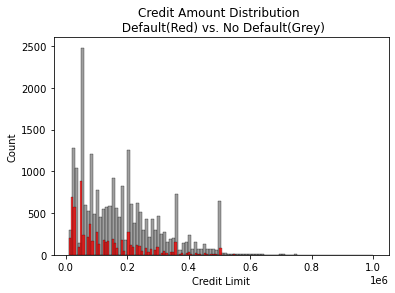

In [31]:
# Credit Amount Distribution
plt.title('Credit Amount Distribution \n Default(Red) vs. No Default(Grey)')
cadist0 = dataset[dataset['default payment next month']==0]['LIMIT_BAL']
cadist1 = dataset[dataset['default payment next month']==1]['LIMIT_BAL']
sns.histplot(cadist0, bins = 100, color = 'grey')
sns.histplot(cadist1, bins = 100, color = 'red')
plt.xlabel('Credit Limit')
plt.show()

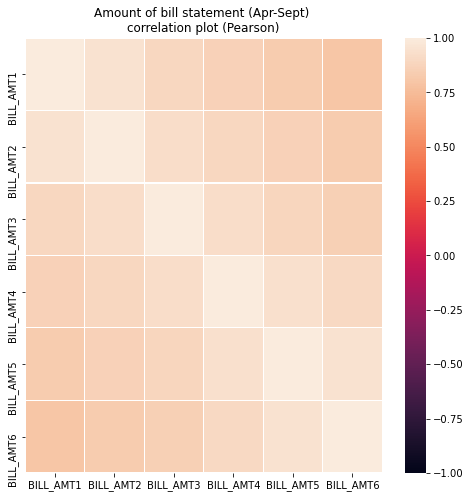

In [33]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = dataset[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

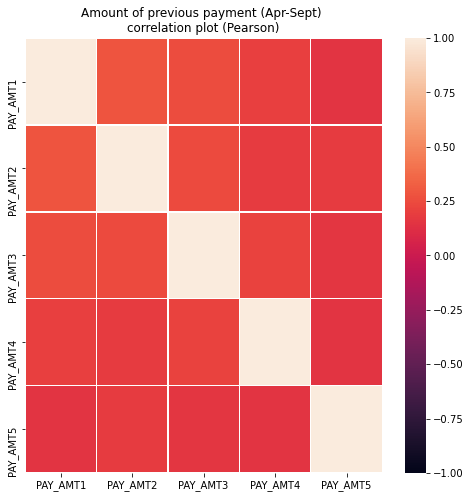

In [35]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = dataset[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

### 魔改特征

我们魔改一下信用卡限额信息 `LIMIT_BAL` 使得该特征对于预测女人来说非常“强”而对男人来说相对“弱”。例如，我们可以想象，较高的信用额度表明女性客户违约的可能性较小，但对男性客户的违约概率没有提供任何信息。

In [8]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

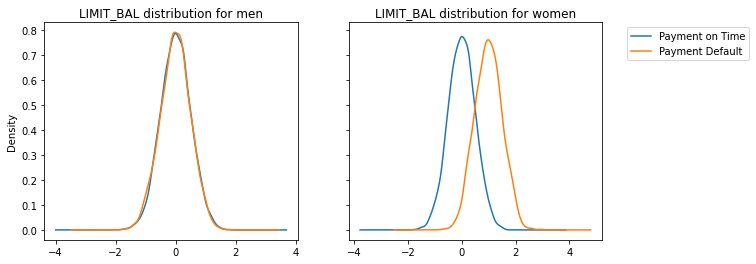

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax1, 
                                           title="LIMIT_BAL distribution for men")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for women")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

我们从上面的数字中注意到，新的`LIMIT_BAL`特征对女性确实有很高的预测性，但对男性则没有。

In [10]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Using a Fairness Unaware Model

We train an out-of-the-box `lightgbm` model on the modified data and assess several disparity metrics. 

In [11]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [12]:
model = lgb.LGBMClassifier(**lgb_params)

In [13]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [14]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [15]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8500200312035275

In [16]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

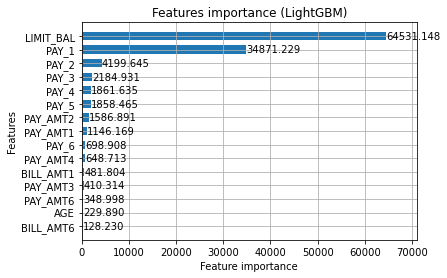

In [17]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

我们注意到人工修改过的特征 `LIMIT_BAL` 作为这个模型中最重要的特征出现，尽管它对数据中的整个人口部分没有预测能力。 

In [18]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        #"Balanced error rate difference": (
        #    lambda x: difference_from_summary(
        #        balanced_accuracy_score_group_summary(y_true, x, sensitive_features=group)), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        #"AUC difference": (
        #    lambda x: difference_from_summary(
        #        roc_auc_score_group_summary(y_true, x, sensitive_features=group)), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

我们在下面计算了几个性能和差异指标：

In [19]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.051105
Demographic parity ratio,0.822500
Overall balanced error rate,0.220682
Equalized odds difference,0.342283
Overall AUC,0.851931


作为总体性能指标，我们使用ROC曲线下的面积（AUC），它适合于正负例子之间有很大不平衡的分类问题。对于二元分类器来说，这与平衡精度是一样的。

作为公平性的衡量标准，我们使用*equalized odds difference*，它量化了不同人口统计学中所经历的准确性的差异。我们的目标是确保两组中的任何一组（男性对女性）的假阳性率或假阴性率都不比另一组大。*equalized odds difference*等于以下两个数字中较大的一个。1）两组的假阳性率之差；（2）两组的假阴性率之差。

上表显示总体AUC为0.85（基于连续预测），总体平衡误差率(overall balanced error)为0.22（基于0/1预测）。在我们的应用环境中，这两点都是令人满意的。然而，准确率有很大的差距,如平衡误差率差异(balanced error rate difference)，当我们考虑到均衡赔率差异(equalized-odds difference)时，差距甚至更大。作为理智的检查，我们还显示了人口学的平准率，其水平（略高于0.8）在这种情况下被认为是令人满意的。

## 通过后处理减小Equalized-Odds Difference

我们尝试缓解 `lightgbm` 预测中的基于敏感特征的结果悬殊，方法是使用Fairlearn postprocessing算法 `ThresholdOptimizer`，该算法通过在equalized-odds difference（在训练数据上）为零的约束条件下优化准确率，为  `lightgbm` 模型产生的分数（类别概率）找到一个合适的阈值。由于我们的目标是优化均衡准确率，我们对训练数据重新取样，使其具有相同数量的正面和负面例子。这意味着 `ThresholdOptimizer` 对于优化在原数据上取得的平衡准确率是非常有效的。

In [20]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds")

In [21]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [22]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [23]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'))

In [24]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [25]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.268111,0.224000
Demographic parity difference,0.051105,0.012961
Demographic parity ratio,0.822500,0.944117
Overall balanced error rate,0.220682,0.322960
Equalized odds difference,0.342283,0.002645
Overall AUC,0.851931,0.677040


`ThresholdOptimizer`算法大大减少了原有的不均衡性。然而，性能指标（平衡错误率以及AUC）变得更糟。在实践中部署这样一个模型之前，重要的是要更详细地研究为什么我们观察到这样的情况。在我们的案例中，这是因为可用的特征对其中一个人口群体的信息量比对另一个人口群体的信息量小得多。

跟不管公平的算法相比`ThresholdOptimizer`产生0/1预测, 所以它的平衡误差率之差等于AUC之差，而它的总体平衡误差率等于1-总体AUC。

接下来，我们在dashboard中比较`lightgbm`模型和这个模型。作为性能指标，我们可以选择均衡准确率。现在的仪表板并不直接显示均衡的赔率差异，但在准确率差异视图中显示了类似的信息，我们可以检查两组的高预测率和低预测率之间的差异。

**未改进模型 vs ThresholdOptimizer: Fairlearn Dashboard**

In [36]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred={"Unmitigated": test_preds,
                          "ThresholdOptimizer": postprocess_preds})

/Users/lee/anaconda3/anaconda3/lib/python3.8/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…

## 用改进 GridSearch 算法改进 Equalized-Odds Difference

我们现在尝试使用 `GridSearch` 算法来缓解差异。与 `ThresholdOptimizer` 不同， `GridSearch` 产生的预测器在测试时不访问敏感特征。另外，我们不是训练单一的模型，而是训练与性能指标（平衡精度）和公平指标（均衡赔率差异）之间的不同权衡点相对应的多个模型。

In [27]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=41,
                   grid_limit=2)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [28]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

In [29]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [30]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

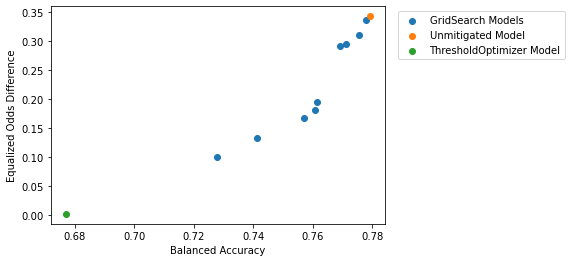

In [31]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

正如预期的那样，`GridSearch` 模型沿着大的平衡精度（但也存在更大的差异问题）和低的差异（更差的平衡精度）之间的权衡曲线出现。这使数据科学家可以灵活地选择一个最适合应用环境的模型。

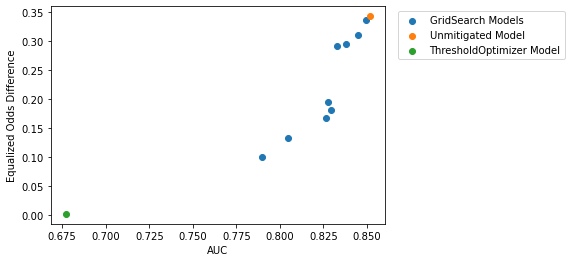

In [32]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [33]:
model_sweep_dict = {"GridSearch_{}".format(i): sweep_preds[i] for i in range(len(sweep_preds)) if non_dominated[i]}
model_sweep_dict.update({"Unmitigated": test_preds, "ThresholdOptimizer": postprocess_preds})

**Grid Search: Dashboard**

我们使用Fairlearn Dashboard将 `GridSearch` 候选模型与未减弱的 `lightgbm` 模型和 `ThresholdOptimizer` 模型进行比较。我们可以选择平衡精度作为性能指标，并检查平衡精度和平衡精度的差异之间的权衡曲线。

In [34]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred=model_sweep_dict)

/Users/lee/anaconda3/anaconda3/lib/python3.8/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…